<a href="https://colab.research.google.com/github/jan-felix/SLOG/blob/master/Metculus_and_Dawum_Scraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 %%capture
!pip install --progress-bar off --quiet poetry
!pip install --progress-bar off --quiet git+https://github.com/oughtinc/ergo.git
import os
os._exit(00)

In [2]:
import pandas as pd
import ergo
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import pandas_datareader as pdr
import datetime
import os

In [3]:
metaculus = ergo.Metaculus()

# Get Predictions

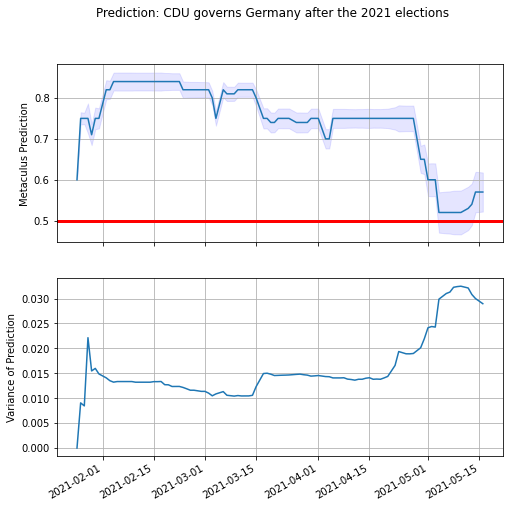

In [7]:
my_pred = 0.5
question_id = 6338
question_name = "Prediction: CDU governs Germany after the 2021 elections"
#def metaculus_question_plot(question_id,question_name,my_pred):
 
binary="yes"
 
#Retrieve and Format Data
question = metaculus.get_question(question_id, name=question_name)
title = question.data["title"]
n_predictions = question.data["number_of_predictions"]
data_hist = question.data["prediction_histogram"]
 
data_ts = pd.DataFrame(question.data["prediction_timeseries"])
data_ts.index = pd.to_datetime(data_ts["t"],unit="s")
data_ts.index = pd.DatetimeIndex(data_ts.index.strftime('%Y-%m-%d'))
data_ts.index.name = None
data_ts = data_ts.drop(columns="t")
data_ts = data_ts.groupby(data_ts.index).last()
 
hist_dist = pd.DataFrame(data_ts["distribution"].tolist())
hist_dist = hist_dist.drop(columns = "num")
hist_dist.index = data_ts.index
hist_dist = hist_dist.groupby(hist_dist.index).last()
 
data_ts["Upper90"] = 1.65*hist_dist["var"]+data_ts["community_prediction"]
data_ts["Lower90"] = -1.65*hist_dist["var"]+data_ts["community_prediction"]
 
fig, axs = plt.subplots(2,1,figsize =(8,8),sharex=True)
fig.suptitle(question_name)
axs[0].plot(data_ts["community_prediction"])
axs[0].fill_between(data_ts["community_prediction"].index, data_ts["Lower90"], data_ts["Upper90"], color='b', alpha=.1)
axs[0].grid()
axs[0].set_ylabel('Metaculus Prediction')
axs[0].axhline(my_pred, linewidth=3, color='r')
axs[1].plot(hist_dist["var"])
axs[1].set_ylabel('Variance of Prediction')
axs[1].grid()
fig.autofmt_xdate()

# Get recent Dawum Data

In [8]:
table_dawum_verlauf = pd.read_html('https://dawum.de/Bundestag/#Umfrageverlauf')
recent_polls = pd.DataFrame(table_dawum_verlauf[0]).set_index(0).dropna(axis=1)
recent_polls.columns = ["Current","Change"]
recent_polls.index.name = None
recent_polls

,Current,Change
Grüne,"25,3%","(−0,4)"
CDU/CSU,"24,7%","(+0,5)"
SPD,"15,0%","(+0,4)"
FDP,"11,0%","(−0,3)"
AfD,"10,8%","(+0,1)"
Linke,"7,0%","(+0,3)"


In [9]:
meta_poll_data = pd.DataFrame(table_dawum_verlauf[1]).set_index(0)
meta_poll_data.columns = ["Value"]
meta_poll_data.index.name = None
meta_poll_data

,Value
Durchschnitt:,7 Wahlumfragen
Gewichtung:,letzter Befragungstag
Veröffentlichung:,30.04. - 16.05.
Befragte:,19419
Vergleich:,zum 08.05.


# Scrape Dawum Chronik

In [10]:
URL = 'https://dawum.de/Bundestag/#Vergleich_mit_Wahlergebnis'
page = requests.get(URL)
#Get Soup
soup = BeautifulSoup(page.content, 'html.parser')
chronik = soup.find(id="Chronik")
table = chronik.find("div",attrs={"class": "table"})
#Create Table
df = pd.DataFrame()
rows = table.findAll("a")
table_list = []
for row in rows: 
  cols = row.findAll("div")
  row_list = []
  for div in cols:
    row_list.append(div.get_text())
  table_list.append(row_list)
 
#Format Data 
rawr_data = pd.DataFrame(table_list)
dates = rawr_data[0].str[0:10]
institute =rawr_data[0].str[10:]
 
rawr_data.columns = ["Institute","Union","Greens","SPD","AFD","FDP","Linke","Freie Wähler","Sonstige"]
 
institute = institute.str.replace('\xad', '') 
institute = [s.strip() for s in institute]
rawr_data["Institute"] = institute

rawr_data.index = pd.DatetimeIndex(pd.to_datetime(dates, dayfirst = True))
rawr_data.index.name = None
rawr_data.drop("Freie Wähler", axis=1)
cols = ["Union","Greens","SPD","AFD","FDP","Linke","Sonstige"]
rawr_data[cols] = rawr_data[cols].apply(lambda x: x.str.replace(',', '.').astype(float), axis=1)
rawr_data = rawr_data.sort_index()

rawr_data = rawr_data.ewm(halflife = 3).mean()


In [12]:
%%capture
rawr_data["Union"].plot()

In [14]:
%%capture
union_vs_greens = rawr_data[["Union","Greens"]]
union_vs_greens["Union-Greens"] = rawr_data["Union"]-rawr_data["Greens"]

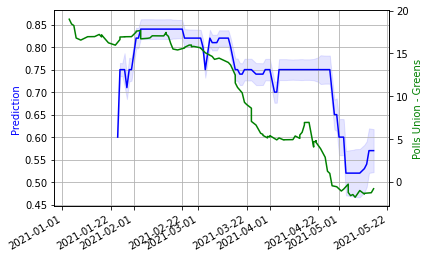

In [15]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(data_ts["community_prediction"], "-b")
ax1.fill_between(data_ts["community_prediction"].index, data_ts["Lower90"], data_ts["Upper90"], color='b', alpha=.1)
ax2.plot(union_vs_greens["Union-Greens"],"-g")

ax1.set_ylabel('Prediction', color='b')
ax2.set_ylabel('Polls Union - Greens', color='g')
ax1.grid()
fig.autofmt_xdate()
plt.show()

In [16]:
start = datetime.datetime(2021, 1, 1)
end = datetime.datetime.today()
index = pd.date_range(start, end, freq="D")
os.environ["ALPHAVANTAGE_API_KEY"] = "H6AXUXK0Z2CBTV59"

ger = pdr.av.time_series.AVTimeSeriesReader(symbols = "EWG",start = start, end = end).read()["close"]
emu = pdr.av.time_series.AVTimeSeriesReader(symbols = "IVV",start = start, end = end).read()["close"]

In [17]:
indices = pd.concat([ger,emu],axis=1)
indices.columns = ["Germany","EMU"]
indices = indices/indices.iloc[0,:]*100
indices["GER/EMU"] = indices["Germany"]/indices["EMU"]
indices.index = pd.DatetimeIndex(indices.index)

In [18]:
index_vs_politics = pd.merge(union_vs_greens, indices, left_index= True, right_index=True)

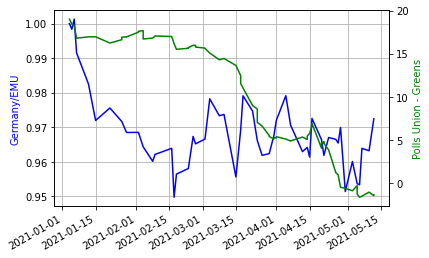

In [19]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(index_vs_politics["GER/EMU"], "-b")
ax2.plot(index_vs_politics["Union-Greens"],"-g")

ax1.set_ylabel('Germany/EMU', color='b')
ax2.set_ylabel('Polls Union - Greens', color='g')
ax1.grid()
fig.autofmt_xdate()
plt.show()

In [21]:
index_vs_politics.drop_duplicates()

,Union,Greens,Union-Greens,Germany,EMU,GER/EMU
2021-01-04,37.000000,18.000000,19.000000,100.000000,100.000000,1.000000
2021-01-05,36.442493,18.000000,18.442493,100.497512,100.661769,0.998368
2021-01-06,36.259921,18.000000,18.259921,101.399254,101.269515,1.001281
2021-01-07,35.828982,19.026111,16.802871,101.896766,102.768624,0.991516
2021-01-12,35.913360,18.956482,16.956878,100.901741,102.695694,0.982531
...,...,...,...,...,...,...
2021-05-06,24.241426,25.842203,-1.600777,108.333333,113.629734,0.953389
2021-05-07,24.397920,25.874757,-1.476837,110.323383,114.453568,0.963914
2021-05-10,24.396383,25.405353,-1.008970,109.172886,113.340716,0.963227
2021-05-12,24.314609,25.734328,-1.419718,106.902985,109.929231,0.972471
